<a href="https://colab.research.google.com/github/GaryM02/applied_predictive_analytics/blob/main/efficientnetv2_downstream_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# connect drive
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/PredictiveAnalyticsProject')

Mounted at /content/drive


In [3]:
# Model Preparation
def prepare_model(model_name, num_classes, pretrained=True):
    """
    Loads a pre-trained model, modifies the classification head for the specified number of classes.
    """
    model = timm.create_model(model_name, pretrained=pretrained)
    if 'vit' in model_name:  # Vision Transformer
        model.head = nn.Linear(model.head.in_features, num_classes)
    elif 'efficientnetv2' in model_name:  # EfficientNetV2
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    else:
        raise ValueError(f"Unsupported model name: {model_name}")
    return model

# Freezing initial layers
def freeze_initial_layers(model, num_layers_to_freeze):
    frozen = 0
    for name, module in model.named_children():
        if frozen < num_layers_to_freeze:
            for param in module.parameters():
                param.requires_grad = False
            frozen += 1
        else:
            break

# Data Loading
def load_data(batch_size=512):
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    train_dataset = datasets.ImageFolder(root='data/train', transform=train_transform)
    val_dataset = datasets.ImageFolder(root='data/validation', transform=val_transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, prefetch_factor=16, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=8, prefetch_factor=16, pin_memory=True)
    return train_loader, val_loader

# Save model state for resume training
def save_checkpoint(model, optimizer, epoch, best_f1, filepath):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'best_f1': best_f1
    }
    torch.save(checkpoint, filepath)

# Load model state for resume training
def load_checkpoint(filepath, model, optimizer):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    best_f1 = checkpoint['best_f1']
    return model, optimizer, epoch, best_f1

# Train one epoch
def train_one_epoch(model, loader, criterion, optimizer, scaler, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    all_labels, all_predictions = [], []

    progress = tqdm(loader, desc="Training", leave=False)
    for images, labels in progress:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Mixed precision forward pass
        with torch.amp.autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

    f1 = f1_score(all_labels, all_predictions, average='weighted')
    return running_loss / len(loader), f1

# Validate the model
def validate_model(model, loader, criterion, device):
    model.eval()
    running_loss, all_labels, all_predictions = 0.0, [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            with torch.amp.autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    f1 = f1_score(all_labels, all_predictions, average='weighted')
    return running_loss / len(loader), f1, all_labels, all_predictions

# Plot metrics
def plot_metrics(metrics):
    plt.figure(figsize=(10, 5))
    for key, values in metrics.items():
        plt.plot(values, label=key)
    plt.legend()
    plt.show()

# Training Loop
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, scaler, device, resume_path=None):
    num_epochs = 25
    early_stopping_patience = 5
    early_stopping_counter = 0
    best_f1 = 0.0
    metrics = {"train_loss": [], "val_loss": [], "train_f1": [], "val_f1": []}
    start_epoch = 0

    # Resume training if a checkpoint is provided
    if resume_path:
        model, optimizer, start_epoch, best_f1 = load_checkpoint(resume_path, model, optimizer)
        print(f"Resumed training from epoch {start_epoch} with best F1: {best_f1:.4f}, lr: {optimizer.param_groups[0]['lr']}")

    for epoch in range(start_epoch, num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        train_loss, train_f1 = train_one_epoch(model, train_loader, criterion, optimizer, scaler, device)
        val_loss, val_f1, val_labels, val_preds = validate_model(model, val_loader, criterion, device)

        metrics["train_loss"].append(train_loss)
        metrics["val_loss"].append(val_loss)
        metrics["train_f1"].append(train_f1)
        metrics["val_f1"].append(val_f1)

        print(f"Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}")

        scheduler.step()

        # Save the best model
        if val_f1 > best_f1:
            best_f1 = val_f1
            save_checkpoint(model, optimizer, epoch, best_f1, "efficientnetv2_best_model.pth")
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        # Early stopping
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

    plot_metrics(metrics)

# Evaluate the model on a test dataset
def evaluate_test_dataset(model, test_loader, device):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Metrics Calculation
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    class_report = classification_report(all_labels, all_predictions, target_names=test_loader.dataset.classes)

    # Print Metrics
    print(f"Weighted F1 Score: {f1:.4f}")
    print("\nClassification Report:\n")
    print(class_report)

    # Confusion Matrix Visualization
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_loader.dataset.classes, yticklabels=test_loader.dataset.classes)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Prepare model and optimizer
model = prepare_model('tf_efficientnetv2_m_in21k', num_classes=10)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnetv2_m_in21k to current tf_efficientnetv2_m.in21k.
  model = create_fn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/325M [00:00<?, ?B/s]

In [6]:
freeze_initial_layers(model, 5)
train_loader, val_loader = load_data(batch_size=128)

In [7]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-3, step_size_up=10, mode='triangular')
scaler = torch.amp.GradScaler('cuda')

Epoch 1/25


Train Loss: 2.3175, Train F1: 0.1644
Val Loss: 2.2002, Val F1: 0.2107
Epoch 2/25


Train Loss: 1.7731, Train F1: 0.3748
Val Loss: 1.5517, Val F1: 0.5094
Epoch 3/25


Train Loss: 1.4457, Train F1: 0.5441
Val Loss: 1.3530, Val F1: 0.6220
Epoch 4/25


Train Loss: 1.3331, Train F1: 0.6093
Val Loss: 1.2932, Val F1: 0.6581
Epoch 5/25


Train Loss: 1.2777, Train F1: 0.6392
Val Loss: 1.2587, Val F1: 0.6701
Epoch 6/25


Train Loss: 1.2491, Train F1: 0.6530
Val Loss: 1.2435, Val F1: 0.6740
Epoch 7/25


Train Loss: 1.2290, Train F1: 0.6680
Val Loss: 1.2405, Val F1: 0.6742
Epoch 8/25


Train Loss: 1.2111, Train F1: 0.6794
Val Loss: 1.2510, Val F1: 0.6751
Epoch 9/25


Train Loss: 1.2104, Train F1: 0.6785
Val Loss: 1.1983, Val F1: 0.6928
Epoch 10/25


Train Loss: 1.2009, Train F1: 0.6874
Val Loss: 1.1987, Val F1: 0.7064
Epoch 11/25


Train Loss: 1.1959, Train F1: 0.6880
Val Loss: 1.2051, Val F1: 0.7007
Epoch 12/25


Train Loss: 1.1878, Train F1: 0.6901
Val Loss: 1.2032, Val F1: 0.6977
Epoch 13/25


Train Loss: 1.1866, Train F1: 0.6899
Val Loss: 1.1870, Val F1: 0.7058
Epoch 14/25


Train Loss: 1.1749, Train F1: 0.6970
Val Loss: 1.1722, Val F1: 0.7157
Epoch 15/25


Train Loss: 1.1688, Train F1: 0.6998
Val Loss: 1.1633, Val F1: 0.7159
Epoch 16/25


Train Loss: 1.1668, Train F1: 0.7025
Val Loss: 1.1738, Val F1: 0.7165
Epoch 17/25


Train Loss: 1.1596, Train F1: 0.7028
Val Loss: 1.1737, Val F1: 0.7130
Epoch 18/25


Train Loss: 1.1534, Train F1: 0.7112
Val Loss: 1.1702, Val F1: 0.7175
Epoch 19/25


Train Loss: 1.1492, Train F1: 0.7083
Val Loss: 1.1685, Val F1: 0.7134
Epoch 20/25


Train Loss: 1.1537, Train F1: 0.7060
Val Loss: 1.1634, Val F1: 0.7161
Epoch 21/25


Train Loss: 1.1461, Train F1: 0.7118
Val Loss: 1.1723, Val F1: 0.7114
Epoch 22/25


Train Loss: 1.1476, Train F1: 0.7124
Val Loss: 1.1701, Val F1: 0.7177
Epoch 23/25


Train Loss: 1.1516, Train F1: 0.7082
Val Loss: 1.1627, Val F1: 0.7179
Epoch 24/25


Train Loss: 1.1530, Train F1: 0.7044
Val Loss: 1.1759, Val F1: 0.7119
Epoch 25/25


Train Loss: 1.1560, Train F1: 0.7050
Val Loss: 1.1640, Val F1: 0.7169


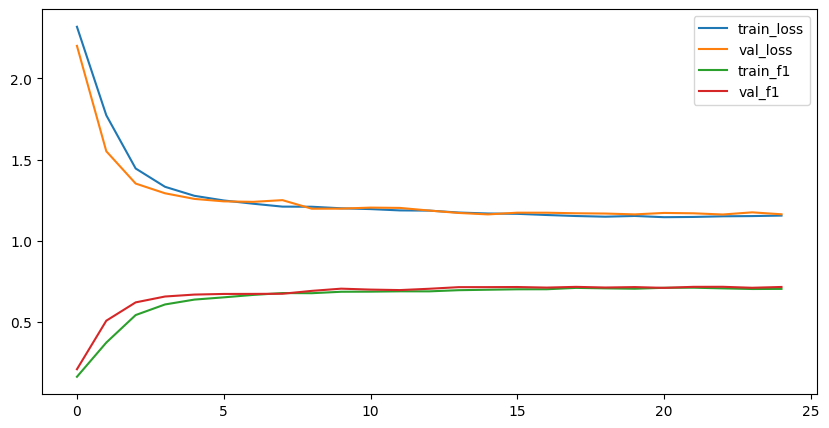

In [8]:
# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, scaler, device)

In [9]:
# evaluate with test set
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
test_dataset = datasets.ImageFolder(root='data/test', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=128, num_workers=8, pin_memory=True)


In [10]:
checkpoint = torch.load('efficientnetv2_best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

<ipython-input-10-d8c42be39cb8>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('efficientnetv2_best_model.pth')


<All keys matched successfully>

Weighted F1 Score: 0.7087

Classification Report:

                               precision    recall  f1-score   support

            Atopic Dermatitis       0.45      0.43      0.44       190
         Basal Cell Carcinoma       0.76      0.90      0.82       499
Benign Keratosis-like Lesions       0.65      0.52      0.58       313
                 Benign Tumor       0.64      0.62      0.63       279
                       Eczema       0.50      0.55      0.53       253
             Fungal Infection       0.52      0.44      0.48       257
             Melanocytic Nevi       0.93      0.85      0.89      1197
                     Melanoma       0.79      0.94      0.86       473
                    Psoriasis       0.46      0.54      0.50       310
             Viral Infections       0.56      0.51      0.53       316

                     accuracy                           0.71      4087
                    macro avg       0.63      0.63      0.62      4087
                 weighte

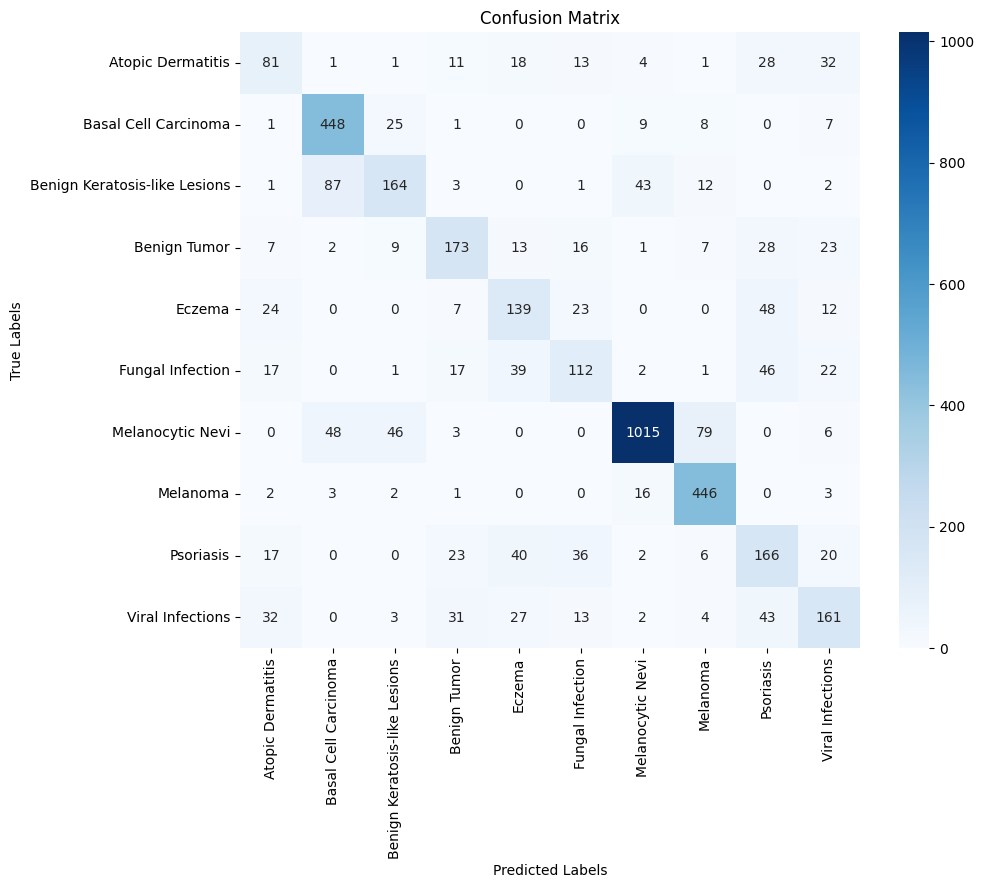

In [11]:
evaluate_test_dataset(model, test_loader, device)